In [2]:
!python -V

Python 3.12.1


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [7]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/03-tracking/mlruns/1', creation_time=1749557367153, experiment_id='1', last_update_time=1749557367153, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
df = pd.read_parquet('./data/green_tripdata_2025-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

6.704280605770969

/tmp/ipykernel_20437/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_20437/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


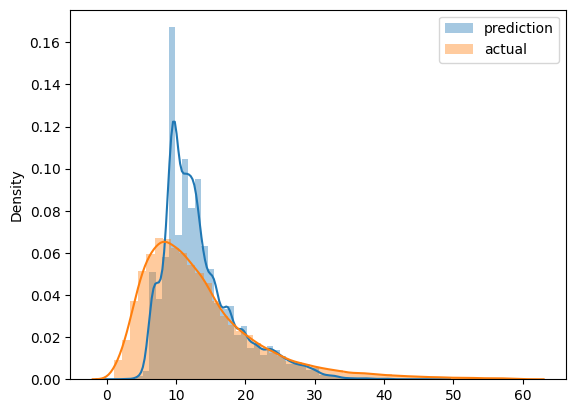

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('./data/green_tripdata_2025-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2025-02.parquet')

In [13]:
len(df_train), len(df_val)

(46307, 44218)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

6.098881864144634

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

8.028312781338874

In [20]:
with mlflow.start_run():
    mlflow.set_tag("developer", "crespil")
    mlflow.set_tag("model", "Lasso")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2025-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2025-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [21]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope




In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):

    with mlflow.start_run(nested=True):

        mlflow.set_tag("developer", "crespil")
        mlflow.set_tag("model", "XGBoost")
        mlflow.log_params(params)

        booster = xgb.train(
            params = params, 
            dtrain = train, 
            num_boost_round = 500,
            evals = [(valid, 'validation')],
            early_stopping_rounds = 20
        )

        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

        return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 1, 100, 2)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, 1),
    'min_child_weigth': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

In [ ]:

mlflow.xgboost.autolog()
params = {
    'learning_rate': 0.08597629437121745,
    'max_depth': 64,
    'min_child_weight': 12.393368691135636,
    'reg_alpha': 0.04899741242232024,
    'reg_lambda': 1.3753994016634536,
    'seed' : 42
 } 


booster = xgb.train(
            params = params, 
            dtrain = train, 
            num_boost_round = 500,
            evals = [(valid, 'validation')],
            early_stopping_rounds = 30
        )

2025/06/10 14:16:38 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.2. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/06/10 14:16:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '23b0e202818f46e09d2a4093db9d4db1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:8.64092
[1]	validation-rmse:8.23018
[2]	validation-rmse:7.86927
[3]	validation-rmse:7.55310
[4]	validation-rmse:7.27691
[5]	validation-rmse:7.03608
[6]	validation-rmse:6.82735
[7]	validation-rmse:6.64660
[8]	validation-rmse:6.49113
[9]	validation-rmse:6.35671
[10]	validation-rmse:6.24093
[11]	validation-rmse:6.14139
[12]	validation-rmse:6.05592
[13]	validation-rmse:5.98327
[14]	validation-rmse:5.91979
[15]	validation-rmse:5.86579
[16]	validation-rmse:5.81970
[17]	validation-rmse:5.78009
[18]	validation-rmse:5.74603
[19]	validation-rmse:5.71592
[20]	validation-rmse:5.69116
[21]	validation-rmse:5.66886
[22]	validation-rmse:5.64966
[23]	validation-rmse:5.63109
[24]	validation-rmse:5.61458
[25]	validation-rmse:5.60074
[26]	validation-rmse:5.58837
[27]	validation-rmse:5.57761
[28]	validation-rmse:5.56840
[29]	validation-rmse:5.56017
[30]	validation-rmse:5.55290
[31]	validation-rmse:5.54656
[32]	validation-rmse:5.54034
[33]	validation-rmse:5.53533
[34]	validation-rmse:5.5

2025/06/10 14:17:49 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/06/10 14:17:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/python/3.12.1/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [14:17:49] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/06/10 14:17:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
